In [222]:
#import get to call a get request on the site
from requests import get

#get the first page of the east bay housing prices
response = get('https://chicago.craigslist.org/search/chc/apa?hasPic=1&availabilityMode=0') #get rid of posts without a pic using their filter

from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')

#get the macro-container for the housing posts
posts = html_soup.find_all('li', class_= 'result-row')
print(type(posts)) #to double check that I got a ResultSet
print(len(posts)) #to double check I got 120 (elements/page)

<class 'bs4.element.ResultSet'>
120


In [0]:
#grab the first post
post_one = posts[0]

In [224]:
#grab the price of the first post
post_one_price = post_one.a.text
post_one_price.strip()

'$2000'

In [0]:
#grab the time of the post in datetime format to save on cleaning efforts
post_one_time = post_one.find('time', class_= 'result-date')
post_one_datetime = post_one_time['datetime']

In [0]:
#title is a and that class, link is grabbing the href attribute of that variable
post_one_title = post_one.find('a', class_='result-title hdrlnk')
post_one_link = post_one_title['href']

#easy to grab the post title by taking the text element of the title variable
post_one_title_text = post_one_title.text

In [228]:
#grabs the whole segment of housing details. We will need missing value handling in the loop as this kind of detail is not common in posts
#the text can be split, and we can use indexing to grab the elements we want. number of bedrooms is the first element.
#sqft is the third element

post_one_num_bedrooms = post_one.find('span', class_ = 'housing').text.split()[0]

post_one_sqft = post_one.find('span', class_ = 'housing').text.split()[2][:-3] #cleans the ft2 at the end

IndexError: ignored

In [0]:
#the neighborhood is grabbed by finding the span class 'result-hood' and pulling the text element from that
post_one_hood = posts[0].find('span', class_='result-hood').text

In [230]:
#build out the loop
from time import sleep
import re
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np

#find the total number of posts to find the limit of the pagination
results_num = html_soup.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array

#each page has 119 posts so each new page is defined as follows: s=120, s=240, s=360, and so on. So we need to step in size 120 in the np.arange function
pages = np.arange(0, results_total+1, 120)

iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
bedroom_counts = []
sqfts = []
post_links = []
post_prices = []

for page in pages:
    
    #get request
    response = get("https://chicago.craigslist.org/search/chc/apa?" 
                   + "s=" #the parameter for defining the page number 
                   + str(page) #the page number in the pages array from earlier
                   + "&hasPic=1"
                   + "&availabilityMode=0")

    sleep(randint(1,5))
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #define the posts
    posts = html_soup.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:

        if post.find('span', class_ = 'result-hood') is not None:

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            #removes the \n whitespace from each side, removes the currency symbol, and turns it into an int
            post_price = int(post.a.text.strip().replace("$", "")) 
            post_prices.append(post_price)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            #    bedroom_counts.append(bedroom_count)
                
            #    sqft = np.nan
            #    sqfts.append(sqft)
                
    iterations += 1
    print("Page " + str(iterations) + " scraped successfully!")

print("\n")

print("Scrape complete!")

Page 1 scraped successfully!
Page 2 scraped successfully!
Page 3 scraped successfully!
Page 4 scraped successfully!
Page 5 scraped successfully!
Page 6 scraped successfully!
Page 7 scraped successfully!
Page 8 scraped successfully!
Page 9 scraped successfully!
Page 10 scraped successfully!
Page 11 scraped successfully!
Page 12 scraped successfully!
Page 13 scraped successfully!
Page 14 scraped successfully!
Page 15 scraped successfully!
Page 16 scraped successfully!
Page 17 scraped successfully!
Page 18 scraped successfully!
Page 19 scraped successfully!
Page 20 scraped successfully!
Page 21 scraped successfully!
Page 22 scraped successfully!
Page 23 scraped successfully!
Page 24 scraped successfully!
Page 25 scraped successfully!
Page 26 scraped successfully!


Scrape complete!


In [231]:
import pandas as pd

eb_apts = pd.DataFrame({'Posted': post_timing,
                       'Neighborhood': post_hoods,
                       'Post_Title': post_title_texts,
                       'Num_Bedrooms': bedroom_counts,
                        'Sqft': sqfts,
                        'URL': post_links,
                       'Price': post_prices})
print(eb_apts.info())
eb_apts.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2652 entries, 0 to 2651
Data columns (total 7 columns):
Posted          2652 non-null object
Neighborhood    2652 non-null object
Post_Title      2652 non-null object
Num_Bedrooms    2132 non-null object
Sqft            832 non-null float64
URL             2652 non-null object
Price           2652 non-null int64
dtypes: float64(1), int64(1), object(5)
memory usage: 145.2+ KB
None


,Posted,Neighborhood,Post_Title,Num_Bedrooms,Sqft,URL,Price
0,2019-12-11 15:13,(Chicago - River West),"True Timber Loft 1B/1B - Exposed Brick, Street Parking, Roof Deck",1,NaN,https://chicago.craigslist.org/chc/apa/d/chicago-true-timber-loft-1b-1b-exposed/7036694247.html,2000
1,2019-12-11 15:13,(Chicago - River North),"River North 2/2, balcony, 1050 sq feet, outdoor pool, Chicago Red Line",2,NaN,https://chicago.craigslist.org/chc/apa/d/chicago-river-north-2-2-balcony-1050-sq/7036693636.html,2385
2,2019-12-11 15:11,(Chicago - River North),"Beautiful Studio, Hardwood, W/D in unit, amazing location!",NaN,NaN,https://chicago.craigslist.org/chc/apa/d/chicago-beautiful-studio-hardwood-d-in/7036692687.html,1560
3,2019-12-11 15:09,(River North),State of the art building is having a special deal on studios,NaN,448.0,https://chicago.craigslist.org/chc/apa/d/chicago-state-of-the-art-building-is/7036691329.html,1648
4,2019-12-11 15:04,(Chicago - The Loop),"Historic Loop Studio - Hardwood, Washer/Dryer, Indoor Pool, Gym",NaN,NaN,https://chicago.craigslist.org/chc/apa/d/chicago-historic-loop-studio-hardwood/7036687683.html,1700
5,2019-12-11 15:04,(Belmont Cragin),2.5 bed all bills included (se habla Espanol),3,NaN,https://chicago.craigslist.org/chc/apa/d/chicago-25-bed-all-bills-included-se/7036687582.html,1250
6,2019-12-11 15:03,(South Shore),MAGNIFICENT🎁 UNIT! A MUST SEE!🎁,NaN,500.0,https://chicago.craigslist.org/chc/apa/d/chicago-magnificent-unit-must-see/7036687126.html,705
7,2019-12-11 14:56,(South Chicago),WINTER W/ FREE HEAT! MUST GIVE US A CALL 📞NOW! HWD FLRS!,3,975.0,https://chicago.craigslist.org/chc/apa/d/chicago-winter-free-heat-must-give-us/7036681477.html,1075
8,2019-12-11 14:54,(Chicago - Fulton River District),"Fulton Market 2B/2B W/D, Balcony, Gym, Pool/Deck",2,NaN,https://chicago.craigslist.org/chc/apa/d/chicago-fulton-market-2b-2b-d-balcony/7036680705.html,2644
9,2019-12-11 14:53,(Chicago - Lakeshore East),"Great value downtown! Convertible near grocery, connected to PEDWAY",1,NaN,https://chicago.craigslist.org/chc/apa/d/chicago-great-value-downtown/7036679571.html,1450


In [0]:
########################DATA CLEANING


In [0]:
#first things first, drop duplicate URLs because people are spammy on Craigslist. 
#Let's see how many uniqe posts we really have.
eb_apts = eb_apts.drop_duplicates(subset='URL')
len(eb_apts.drop_duplicates(subset='URL'))

#make the number bedrooms to a float (since np.nan is a float too)
eb_apts['Num_Bedrooms'] = eb_apts['Num_Bedrooms'].apply(lambda x: float(x))

#convert datetime string into datetime object to be able to work with it
from datetime import datetime

eb_apts['Posted'] = pd.to_datetime(eb_apts['Posted'])

#Looking at what neighborhoods there are with eb_apts['neighborhood'].unique() allowed me to see what
#I needed to deal with in terms of cleaning those.

#remove the parenthesis from the left and right of the neighborhoods
eb_apts['Neighborhood'] = eb_apts['Neighborhood'].map(lambda x: x.lstrip('(').rstrip(')'))

eb_rooms['neighborhood'] = eb_rooms['neighborhood'].apply(lambda x: re.sub(r'[()]+', '', x))

#titlecase them
eb_apts['Neighborhood'] = eb_apts['Neighborhood'].str.title()

#just take the first name of the neighborhood list, splitting on the '/' delimiter
eb_apts['Neighborhood'] = eb_apts['Neighborhood'].apply(lambda x: x.split('/')[0])

#fix one-offs that
########################
#####################
######################
#UPDATE
######################
#####################
###################
########################
#eb_apts['Neighborhood'].replace('Belmont, Ca', 'Belmont', inplace=True)
#eb_apts['Neighborhood'].replace('Hercules, Pinole, San Pablo, El Sob', 'Hercules', inplace=True)

#remove whitespaces
eb_apts['Neighborhood'] = eb_apts['Neighborhood'].apply(lambda x: x.strip())

In [249]:
### EXPLORATORY DATA ANALYSIS
eb_apts.head(1)

,Posted,Neighborhood,Post_Title,Num_Bedrooms,Sqft,URL,Price
0,2019-12-11 15:13:00,Chicago - River West,"True Timber Loft 1B/1B - Exposed Brick, Street Parking, Roof Deck",1.0,NaN,https://chicago.craigslist.org/chc/apa/d/chicago-true-timber-loft-1b-1b-exposed/7036694247.html,2000


In [251]:
for Post_Title in eb_apts:
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Andersonville'), 'Neighborhood'] = 'Andersonville'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('andersonville'), 'Neighborhood'] = 'Andersonville'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Archer Heights'), 'Neighborhood'] = 'Archer Heights'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('archer Heights'), 'Neighborhood'] = 'Archer Heights'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Ashburn'), 'Neighborhood'] = 'Ashburn'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('ashburn'), 'Neighborhood'] = 'Ashburn'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Austin'), 'Neighborhood'] = 'Austin'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('austin'), 'Neighborhood'] = 'Austin'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('avon'), 'Neighborhood'] = 'Avondale'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Avon'), 'Neighborhood'] = 'Avondale'  
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Albany'), 'Neighborhood'] = 'Albany Park'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('albany'), 'Neighborhood'] = 'Albany Park'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Beverly'), 'Neighborhood'] = 'Beverly'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('beverly'), 'Neighborhood'] = 'Beverly'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('buck'), 'Neighborhood'] = 'Bucktown'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Buck'), 'Neighborhood'] = 'Bucktown'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Boys'), 'Neighborhood'] = 'Boystown'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('boys'), 'Neighborhood'] = 'Boystown'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('China'), 'Neighborhood'] = 'Chinatown'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('china'), 'Neighborhood'] = 'Chinatown'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Depaul'), 'Neighborhood'] = 'Depaul'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('depaul'), 'Neighborhood'] = 'Depaul'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Edison'), 'Neighborhood'] = 'Edison Park'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('edison'), 'Neighborhood'] = 'Edison Park'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Edgewater'), 'Neighborhood'] = 'Edgewater'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('edgewater'), 'Neighborhood'] = 'Edgewater'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Englewood'), 'Neighborhood'] = 'Englewood'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('englewood'), 'Neighborhood'] = 'Englewood'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Galewood'), 'Neighborhood'] = 'Galewood'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('galewood'), 'Neighborhood'] = 'Galewood'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Garfield Park'), 'Neighborhood'] = 'Garfield Park'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('garfield Park'), 'Neighborhood'] = 'Garfield Park'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Gold Coast'), 'Neighborhood'] = 'Gold Coast'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('gold'), 'Neighborhood'] = 'Gold Coast'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Gresham'), 'Neighborhood'] = 'Gresham'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('gresham'), 'Neighborhood'] = 'Gresham'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Humb'), 'Neighborhood'] = 'Humboldt Park'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('humb'), 'Neighborhood'] = 'Humboldt Park'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Hyde'), 'Neighborhood'] = 'Hyde Park'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('hyde'), 'Neighborhood'] = 'Hyde Park'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Jefferson'), 'Neighborhood'] = 'Jefferson Park'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('jefferson'), 'Neighborhood'] = 'Jefferson Park'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Kenwood'), 'Neighborhood'] = 'Kenwood'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('kenwood'), 'Neighborhood'] = 'Kenwood'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Lakeview'), 'Neighborhood'] = 'Lakeview'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('lakeview'), 'Neighborhood'] = 'Lakeview'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Little Village'), 'Neighborhood'] = 'Little Village'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Little village'), 'Neighborhood'] = 'Little Village'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('little village'), 'Neighborhood'] = 'Little Village'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('lil village'), 'Neighborhood'] = 'Little Village'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Lil village'), 'Neighborhood'] = 'Little Village'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Lincoln Park'), 'Neighborhood'] = 'Lincoln Park'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('lincoln park'), 'Neighborhood'] = 'Lincoln Park'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Lincoln Square'), 'Neighborhood'] = 'Lincoln Square'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('lincoln square'), 'Neighborhood'] = 'Lincoln Square'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Logan'), 'Neighborhood'] = 'Logan Square'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('logan'), 'Neighborhood'] = 'Logan Square'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Marquette Park'), 'Neighborhood'] = 'Marquette Park'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('marquette park'), 'Neighborhood'] = 'Marquette Park'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Midway'), 'Neighborhood'] = 'Midway'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('midway'), 'Neighborhood'] = 'Midway'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Mount Greenwood'), 'Neighborhood'] = 'Mount Greenwood'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('mount greenwood'), 'Neighborhood'] = 'Mount Greenwood'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Norwood'), 'Neighborhood'] = 'Norwood Park'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('norwood'), 'Neighborhood'] = 'Norwood Park'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Irving'), 'Neighborhood'] = 'Irving Park'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('irving'), 'Neighborhood'] = 'Irving Park'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Old Town'), 'Neighborhood'] = 'Old Town'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('old town'), 'Neighborhood'] = 'Old Town'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Pilsen'), 'Neighborhood'] = 'Pilsen'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('pilsen'), 'Neighborhood'] = 'Pilsen'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Portage'), 'Neighborhood'] = 'Portage Park'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('portage'), 'Neighborhood'] = 'Portage Park'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Pullman'), 'Neighborhood'] = 'Pullman'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('pullman'), 'Neighborhood'] = 'Pullman'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Ravens'), 'Neighborhood'] = 'Ravenswood'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('ravens'), 'Neighborhood'] = 'Ravenswood'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('River North'), 'Neighborhood'] = 'River North'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('river north'), 'Neighborhood'] = 'River North'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('River West'), 'Neighborhood'] = 'River West'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('river west'), 'Neighborhood'] = 'River West'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Rogers'), 'Neighborhood'] = 'Rogers Park'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('rogers'), 'Neighborhood'] = 'Rogers Park'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('rodgers'), 'Neighborhood'] = 'Rogers Park'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Roscoe Village'), 'Neighborhood'] = 'Roscoe Village'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('roscoe village'), 'Neighborhood'] = 'Roscoe Village'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Sauganash'), 'Neighborhood'] = 'Sauganash'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('sauganash'), 'Neighborhood'] = 'Sauganash'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('South Loop'), 'Neighborhood'] = 'South Loop'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('south loop'), 'Neighborhood'] = 'South Loop'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('South Shore'), 'Neighborhood'] = 'South Shore'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('south shore'), 'Neighborhood'] = 'South Shore'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Streeter'), 'Neighborhood'] = 'Streeterville'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('streeter'), 'Neighborhood'] = 'Streeterville'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Uptown'), 'Neighborhood'] = 'Uptown'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('uptown'), 'Neighborhood'] = 'Uptown'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('West Loop'), 'Neighborhood'] = 'West Loop'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('west loop'), 'Neighborhood'] = 'West Loop'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('West Town'), 'Neighborhood'] = 'West Town'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('west town'), 'Neighborhood'] = 'West Town'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Wicker'), 'Neighborhood'] = 'Wicker Park'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('wicker'), 'Neighborhood'] = 'Wicker Park'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Wrigleyville'), 'Neighborhood'] = 'Wrigleyville'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('wrigleyville'), 'Neighborhood'] = 'Wrigleyville'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('wrigley'), 'Neighborhood'] = 'Wrigleyville'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('Ukrainian Village'), 'Neighborhood'] = 'Ukrainian Village'
  eb_apts.loc[eb_apts['Post_Title'].str.contains('ukrainian village'), 'Neighborhood'] = 'Ukrainian Village'

eb_apts

,Posted,Neighborhood,Post_Title,Num_Bedrooms,Sqft,URL,Price
0,2019-12-11 15:13:00,Chicago - River West,"True Timber Loft 1B/1B - Exposed Brick, Street Parking, Roof Deck",1.0,NaN,https://chicago.craigslist.org/chc/apa/d/chicago-true-timber-loft-1b-1b-exposed/7036694247.html,2000
1,2019-12-11 15:13:00,River North,"River North 2/2, balcony, 1050 sq feet, outdoor pool, Chicago Red Line",2.0,NaN,https://chicago.craigslist.org/chc/apa/d/chicago-river-north-2-2-balcony-1050-sq/7036693636.html,2385
2,2019-12-11 15:11:00,Chicago - River North,"Beautiful Studio, Hardwood, W/D in unit, amazing location!",NaN,NaN,https://chicago.craigslist.org/chc/apa/d/chicago-beautiful-studio-hardwood-d-in/7036692687.html,1560
3,2019-12-11 15:09:00,River North,State of the art building is having a special deal on studios,NaN,448.0,https://chicago.craigslist.org/chc/apa/d/chicago-state-of-the-art-building-is/7036691329.html,1648
4,2019-12-11 15:04:00,Chicago - The Loop,"Historic Loop Studio - Hardwood, Washer/Dryer, Indoor Pool, Gym",NaN,NaN,https://chicago.craigslist.org/chc/apa/d/chicago-historic-loop-studio-hardwood/7036687683.html,1700
5,2019-12-11 15:04:00,Belmont Cragin,2.5 bed all bills included (se habla Espanol),3.0,NaN,https://chicago.craigslist.org/chc/apa/d/chicago-25-bed-all-bills-included-se/7036687582.html,1250
6,2019-12-11 15:03:00,South Shore,MAGNIFICENT🎁 UNIT! A MUST SEE!🎁,NaN,500.0,https://chicago.craigslist.org/chc/apa/d/chicago-magnificent-unit-must-see/7036687126.html,705
7,2019-12-11 14:56:00,South Chicago,WINTER W/ FREE HEAT! MUST GIVE US A CALL 📞NOW! HWD FLRS!,3.0,975.0,https://chicago.craigslist.org/chc/apa/d/chicago-winter-free-heat-must-give-us/7036681477.html,1075
8,2019-12-11 14:54:00,Chicago - Fulton River District,"Fulton Market 2B/2B W/D, Balcony, Gym, Pool/Deck",2.0,NaN,https://chicago.craigslist.org/chc/apa/d/chicago-fulton-market-2b-2b-d-balcony/7036680705.html,2644
9,2019-12-11 14:53:00,Chicago - Lakeshore East,"Great value downtown! Convertible near grocery, connected to PEDWAY",1.0,NaN,https://chicago.craigslist.org/chc/apa/d/chicago-great-value-downtown/7036679571.html,1450


In [252]:
eb_apts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102 entries, 0 to 101
Data columns (total 7 columns):
Posted          102 non-null datetime64[ns]
Neighborhood    102 non-null object
Post_Title      102 non-null object
Num_Bedrooms    82 non-null float64
Sqft            32 non-null float64
URL             102 non-null object
Price           102 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.4+ KB


In [237]:
import pandas as pd, numpy as np
#chicago_apts = pd.read_csv("chicago_apts.csv")

FileNotFoundError: ignored

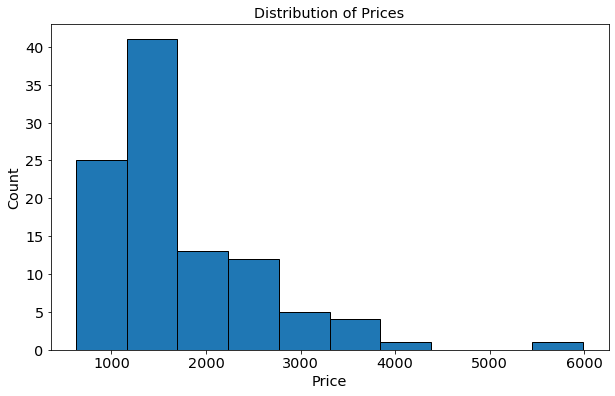

In [253]:
#start to look at the distributions
from matplotlib import figure
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.hist(eb_apts['Price'], edgecolor='black');
plt.xlabel("Price")
plt.ylabel('Count')
plt.title("Distribution of Prices");

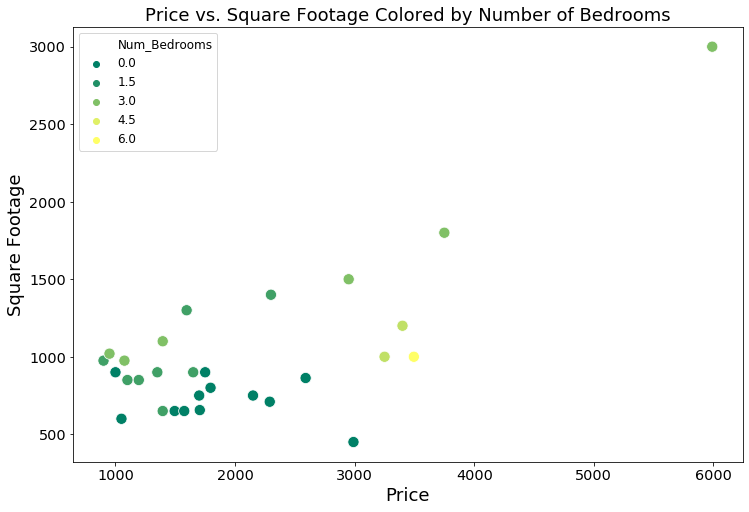

In [254]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='Price', y='Sqft', hue='Num_Bedrooms', palette='summer', x_jitter=True, y_jitter=True, s=125, data=eb_apts.dropna())
plt.legend(fontsize=12)
plt.xlabel("Price", fontsize=18)
plt.ylabel("Square Footage", fontsize=18);
plt.title("Price vs. Square Footage Colored by Number of Bedrooms", fontsize=18);

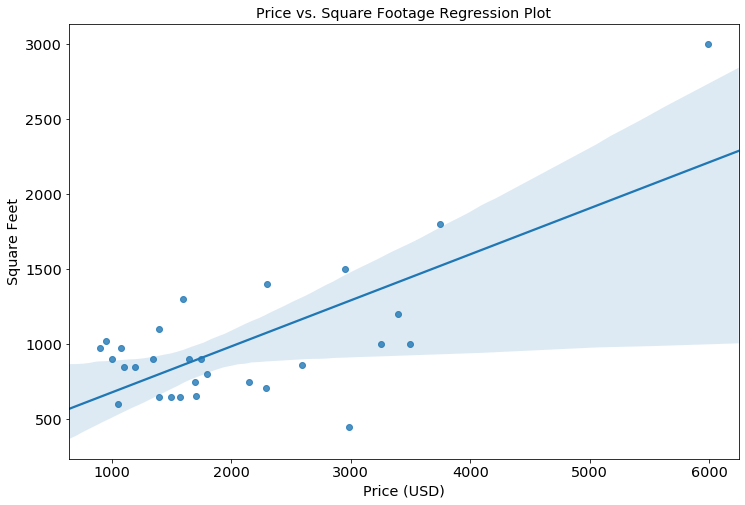

In [255]:
plt.figure(figsize=(12, 8))
sns.regplot(x='Price', y='Sqft', data=eb_apts.dropna());
plt.title('Price vs. Square Footage Regression Plot');
plt.xlabel("Price (USD)");
plt.ylabel("Square Feet");

In [256]:
eb_apts.corr()

,Num_Bedrooms,Sqft,Price
Num_Bedrooms,1.000000,0.472064,0.550991
Sqft,0.472064,1.000000,0.727463
Price,0.550991,0.727463,1.000000


In [257]:
#group by neighborhood
eb_apts.groupby('Neighborhood').mean()

,Num_Bedrooms,Sqft,Price
Neighborhood,,,
2126 N Sheffield,4.000000,1000.00,3250.000000
2126 N Sheffield Ave,4.000000,1200.00,3400.000000
2711 N Kenmore St.,5.000000,1000.00,3495.000000
3422 Lavergne,1.000000,600.00,1050.000000
62Nd & Greenwood,1.000000,NaN,700.000000
6725 S. East End,3.000000,NaN,1550.000000
810 Seward - Evanston,2.000000,NaN,1350.000000
Albany Park,1.500000,NaN,1262.500000
Belmont Cragin,3.000000,NaN,1250.000000


In [258]:
#sort price to find cheapest
eb_apts.groupby('Neighborhood').mean()['Price'].sort_values()

Neighborhood
Midway Area                         625.000000
62Nd & Greenwood                    700.000000
South Shore                         827.500000
Irving Park                         850.000000
Rogers Park East                    850.000000
West Rogers Park                    975.000000
West Ridge                         1025.000000
Rogers Park                        1041.666667
3422 Lavergne                      1050.000000
South Chicago                      1075.000000
Portage Park                       1100.000000
Pilsen                             1100.000000
South Douglas Park West Pilsen     1195.000000
Belmont Cragin                     1250.000000
Albany Park                        1262.500000
Hermosa                            1295.000000
Edgewater                          1296.666667
Uptown                             1337.444444
810 Seward - Evanston              1350.000000
Milwaukee                          1375.000000
Lincoln Square                     1415.000000


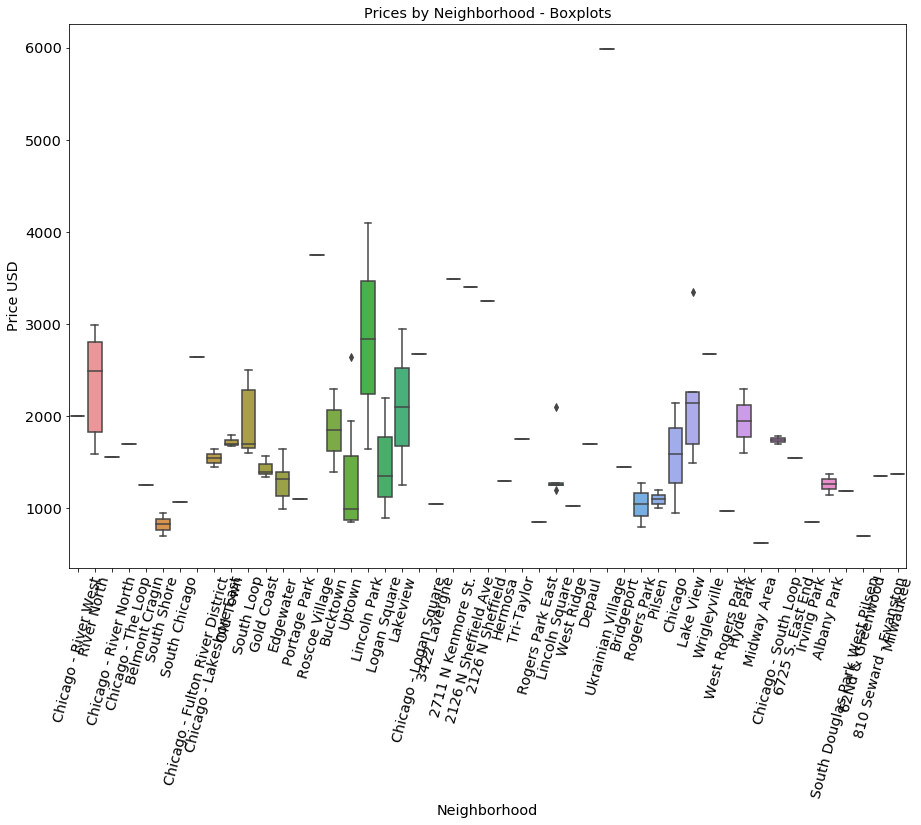

In [259]:
plt.figure(figsize=(15,10))
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

sns.boxplot(x='Neighborhood', y='Price', data=eb_apts)
plt.xlabel("Neighborhood");
plt.xticks(rotation=75)
plt.ylabel("Price USD");
plt.title("Prices by Neighborhood - Boxplots");